In [61]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [62]:
# API configuration - Flu hospital admission rate (weekly) for England
BASE_URL = "https://api.ukhsa-dashboard.data.gov.uk"
THEME = "infectious_disease"
SUB_THEME = "respiratory"
TOPIC = "Influenza"  # Exact topic name
GEOGRAPHY_TYPE = "Nation"
GEOGRAPHY = "England"
METRIC = "influenza_healthcare_hospitalAdmissionRateByWeek"  # Key flu metric

# Function to fetch all paginated data
def fetch_flu_data():
    url = f"{BASE_URL}/themes/{THEME}/sub_themes/{SUB_THEME}/topics/{TOPIC}/geography_types/{GEOGRAPHY_TYPE}/geographies/{GEOGRAPHY}/metrics/{METRIC}"
    data = []
    params = {"page_size": 500}  # Larger page size for efficiency
    
    while url:
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error fetching data: {response.status_code} - {response.text}")
            break
        
        json_data = response.json()
        results = json_data.get("results", [])
        if not results:
            print("No data returned for this metric.")
            break
        
        data.extend(results)
        url = json_data.get("next")  # None if last page
        params = {}  # Clear params for next pages (they are in the 'next' URL)
    
    print(f"Fetched {len(data)} data points for flu hospital admissions.")
    return data

In [63]:
def process_data(raw_data):
    if not raw_data:
        print("No raw data to process.")
        return None
    
    df = pd.DataFrame(raw_data)
    
    # Debug: Print columns and a sample row to see structure
    print("Available columns:", df.columns.tolist())
    print("Sample data row:\n", df.iloc[0] if not df.empty else "Empty DataFrame")
    
    # Common keys in UKHSA API: 'metric_value', 'value', or sometimes nested
    value_key = None
    for possible in ['metric_value', 'value', 'metricValue']:
        if possible in df.columns:
            value_key = possible
            break
    
    if value_key is None:
        print("Error: No value column found! Check API response structure.")
        return None
    
    # Key columns: 'date' and the value key
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # Rename to 'value' for consistency in plotting
    df = df.rename(columns={value_key: 'value'})
    
    # Simple analysis
    df['rolling_7_week_avg'] = df['value'].rolling(window=7).mean()
    
    # Extract year/week for seasonal comparison
    df['season_year'] = df['date'].dt.year
    df['week'] = df['date'].dt.isocalendar().week
    
    # Save to CSV
    df.to_csv('flu_data.csv', index=False)
    print("Data saved to flu_data.csv")
    return df

Fetching UK flu hospital admission data...
Fetched 2778 data points for flu hospital admissions.
Available columns: ['theme', 'sub_theme', 'topic', 'geography_type', 'geography', 'geography_code', 'metric', 'metric_group', 'stratum', 'sex', 'age', 'year', 'month', 'epiweek', 'date', 'metric_value', 'in_reporting_delay_period']
Sample data row:
 theme                                                      infectious_disease
sub_theme                                                         respiratory
topic                                                               Influenza
geography_type                                                         Nation
geography                                                             England
geography_code                                                      E92000001
metric                       influenza_healthcare_hospitalAdmissionRateByWeek
metric_group                                                       healthcare
stratum                      

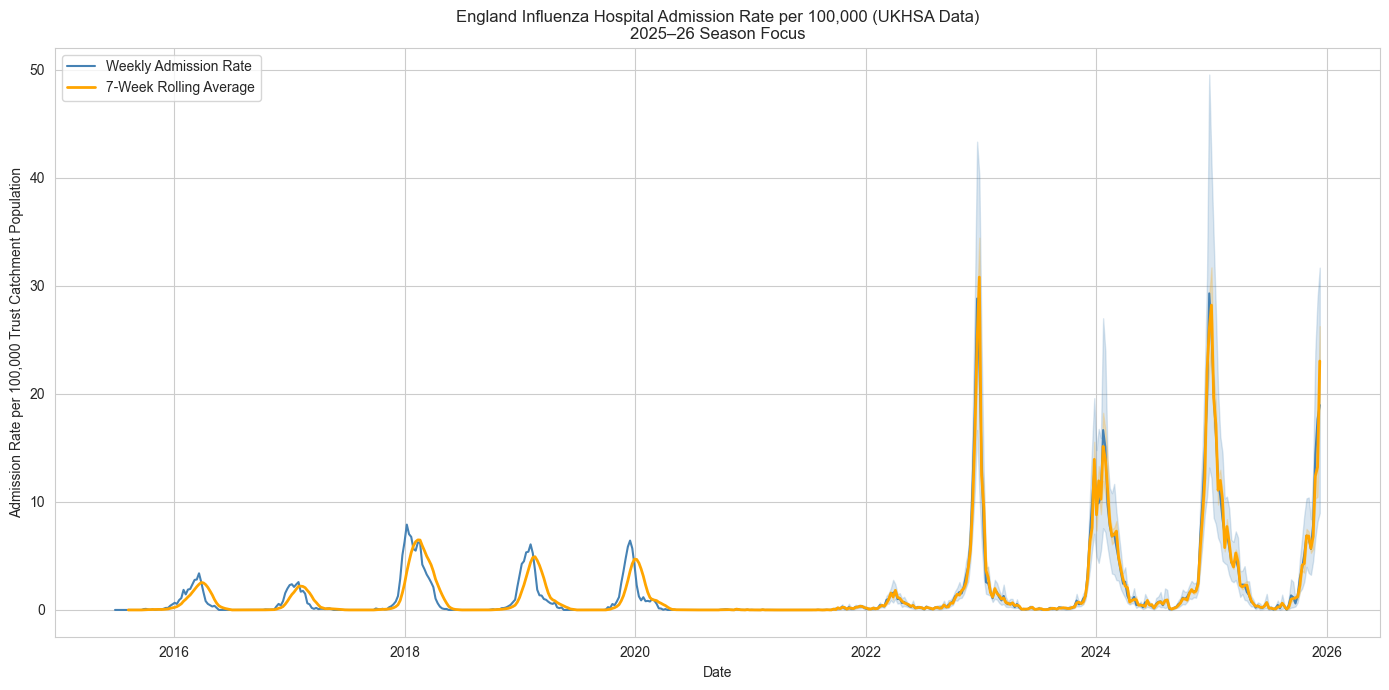

Plot saved to flu_trends.png

Latest data (2025-12-08): 4.67 admissions per 100,000


In [64]:
# Visualise
def plot_flu_trends(df):
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")
    
    sns.lineplot(data=df, x='date', y='value', label='Weekly Admission Rate', color='steelblue')
    sns.lineplot(data=df, x='date', y='rolling_7_week_avg', label='7-Week Rolling Average', color='orange', linewidth=2)
    
    plt.title('England Influenza Hospital Admission Rate per 100,000 (UKHSA Data)\n2025–26 Season Focus')
    plt.xlabel('Date')
    plt.ylabel('Admission Rate per 100,000 Trust Catchment Population')
    plt.legend()
    plt.tight_layout()
    plt.savefig('flu_trends.png')
    plt.show()
    print("Plot saved to flu_trends.png")

if __name__ == "__main__":
    print("Fetching UK flu hospital admission data...")
    raw_data = fetch_flu_data()
    
    if raw_data:
        df = process_data(raw_data)
        plot_flu_trends(df)
        
        # Quick summary
        latest_date = df['date'].max()
        latest_rate = df.loc[df['date'] == latest_date, 'value'].values[0]
        print(f"\nLatest data ({latest_date.date()}): {latest_rate:.2f} admissions per 100,000")
    else:
        print("No data fetched. Check API status or metric availability.")